## Numpy tests

In [1]:
import numpy as np
print('OK')

OK


## Charge parameters

In [1]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Chronics import MultifolderWithCache
from l2rpn_baselines.utils import GymEnvWithRecoWithDN
from grid2op.Parameters import Parameters
from grid2op.utils import ScoreL2RPN2020
import torch
import datetime
import sys
import re
import os

from utils import *

from examples.ppo_stable_baselines.B_train_agent import CustomReward

2022-05-05 13:43:23.968775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 13:43:23.968799: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ENV_NAME = "l2rpn_wcci_2022_dev"

# Split sets and statistics parameters
is_windows = sys.platform.startswith("win32")
is_windows_or_darwin = sys.platform.startswith("win32") or sys.platform.startswith("darwin")
nb_process_stats = 4 if not is_windows_or_darwin else 1
deep_copy = is_windows  # force the deep copy on windows (due to permission issue in symlink in windows)
verbose = 1
SCOREUSED = ScoreL2RPN2020  # ScoreICAPS2021
name_stats = "_reco_powerline"

# Train parameters
env_name_train = '_'.join([ENV_NAME, "train"])
save_path = "./saved_model"
name = '_'.join(["GymEnvWithRecoWithDN", datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')])
gymenv_class = GymEnvWithRecoWithDN

In [3]:
def filter_chronics(x):
  list_chronics = ['2050-01-10_0', '2050-08-01_7'] # Names of chronics to keep
  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None

In [4]:
p=Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True

env_train = grid2op.make(ENV_NAME,
                   reward_class=CustomReward,
                   backend=LightSimBackend(),
                   chronics_class=MultifolderWithCache,
                   param=p)
env_train.chronics_handler.real_data.set_filter(filter_chronics)
env_train.chronics_handler.real_data.reset()

array(['/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-01-10_0',
       '/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-08-01_7'],
      dtype='<U75')

## Test Runner

In [7]:
from grid2op.Runner import Runner
from examples.ppo_stable_baselines.C_evaluate_trained_model import load_agent

from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(observation_space=env_train.observation_space)

In [8]:
agent_name = "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2"
path_agent = os.path.join(save_path, agent_name)
path_results_agent = os.path.join("./model_results", agent_name)

In [7]:
my_agent = load_agent(env_train, 
    load_path=save_path, 
    name=agent_name, 
    gymenv_class=gymenv_class, 
    gymenv_kwargs={"safe_max_rho": 0.9})

In [8]:
runner_params = env_train.get_params_for_runner()
runner_params["verbose"] = verbose
runner = Runner(**runner_params, agentClass=None, agentInstance=my_agent)

In [12]:
os.makedirs(path_results_agent, exist_ok=True)

res = runner.run(path_save=path_results_agent, 
    nb_episode=2, 
    nb_process=1, 
    max_iter=-1, 
    pbar=True,
    env_seeds=get_env_seed(ENV_NAME)[:2], 
    # env_seeds=[42 for _ in range(2)],
    agent_seeds=[0 for _ in range(2)])

episode:  36%|███▌      | 728/2017 [00:02<00:04, 316.11it/s]


2050-01-10_0: env.nb_time_step = 728, reward : 0.601


episode:  64%|██████▍   | 1290/2017 [00:03<00:01, 386.86it/s]


2050-08-01_7: env.nb_time_step = 1290, reward : 0.800


episode: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


In [10]:
for i, agent_name in enumerate(["GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0", 
                      "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_1", 
                      "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2"]):
  results = eval_agent(ENV_NAME, #env_name_val,
            2,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs={"safe_max_rho":0.9},
            param=p,
            filter_fun=filter_chronics)
  print(results)


Starts the evaluation of the agent
Start the evaluation of the scores
	:-) I survived 722 steps vs 280 for do nothing (442)
	:-) I survived 1289 steps vs 127 for do nothing (1162)
The agent "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0" beats "do nothing" baseline in 2 out of 2 episodes
	:-) I survived 722 steps vs 280 for reco powerline (442)
	:-) I survived 1289 steps vs 131 for reco powerline (1158)
The agent "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0" beats "reco powerline" baseline in 2 out of 2 episodes
([722, 1289], array([280, 127]), array([280, 131]))
Starts the evaluation of the agent
Start the evaluation of the scores
	:-) I survived 390 steps vs 280 for do nothing (110)
	:-) I survived 1574 steps vs 127 for do nothing (1447)
The agent "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_1" beats "do nothing" baseline in 2 out of 2 episodes
	:-) I survived 390 steps vs 280 for reco powerline (110)
	:-) I survived 1574 steps vs 131 for reco powerline (144

## Study episodes

In [31]:
from grid2op.Episode import EpisodeData
episode_studied = EpisodeData.list_episode(path_results_agent)
episode_studied

[('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2',
  '2050-01-10_0'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2',
  '2050-08-01_7')]

In [32]:
this_episode = EpisodeData.from_disk(*episode_studied[0])

In [33]:
for t, act in enumerate(this_episode.actions):
    if act != env_train.action_space(): # Print only when an action is done
        obs = this_episode.observations[t]
        print(np.max(obs.rho))
        print(t)
        print(act)
        # _ = plot_helper.plot_obs(obs)

0.9082976
0
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - Modify the storage units in the following way:
	 	 - Ask unit "storage_22_0" to produce 12.00 MW (setpoint: -12.00 MW)
	 	 - Ask unit "storage_41_1" to produce 12.00 MW (setpoint: -12.00 MW)
	 	 - Ask unit "storage_44_2" to absorb 12.00 MW (setpoint: 12.00 MW)
	 	 - Ask unit "storage_58_3" to produce 12.00 MW (setpoint: -12.00 MW)
	 	 - Ask unit "storage_76_4" to produce 12.00 MW (setpoint: -12.00 MW)
	 	 - Ask unit "storage_95_5" to produce 12.00 MW (setpoint: -12.00 MW)
	 	 - Ask unit "storage_112_6" to absorb 12.00 MW (setpoint: 12.00 MW)
	 - Perform the following curtailment:
	 	 - Limit unit "gen_3_0" to 0.0% of its Pmax (setpoint: 0.000)
	 	 - Limit unit "gen_3_1" to 0.0% of its Pmax (setpoint: 0.000)
	 	 - Limit unit "gen_9_3" to 0.0% of its Pmax (setpoint: 0.000)
	 	 - Limit unit "gen_10_4" to 0.0% of its Pmax (setpoint: 0.000)
	 	 - Limit unit "gen_10_5" to 100.

## Training curves

In [46]:
from l2rpn_baselines.PPO_SB3 import evaluate
trained_agent, details = evaluate(env_train,
                                nb_episode=2,
                                load_path=save_path,
                                name=agent_name,
                                gymenv_class=gymenv_class,
                                iter_num=700000,
                                # iter_num=630000,
                                gymenv_kwargs={"safe_max_rho":0.9})

2050-01-10_0: env.nb_time_step = 855, reward : 0.651
2050-08-01_7: env.nb_time_step = 116, reward : 0.240


In [54]:
details

[('/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-01-10_0',
  '2050-01-10_0',
  0.651073633738405,
  855,
  2017),
 ('/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-08-01_7',
  '2050-08-01_7',
  0.23981483519782887,
  116,
  2017)]

In [92]:
nb_iterations = 700_000
nb_iterations_list = np.arange(stop=nb_iterations+1, step=nb_iterations//10)[1:]
agents_names_list = ["GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0", 
                      "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_1", 
                      "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2"]

agents_names_list = ["GymEnvWithRecoWithDN_2022-04-26_19-08_learning_rate_0", 
                      "GymEnvWithRecoWithDN_2022-04-26_19-08_learning_rate_1", 
                      "GymEnvWithRecoWithDN_2022-04-27_17-51_gymenv_kwargs_0"]

global_res = np.zeros((2, 3, 2, nb_iterations_list.shape[0]))

for i, agent_name in enumerate(agents_names_list):
    for j, nb_iter in enumerate(nb_iterations_list):
        _, details = evaluate(env_train,
                                nb_episode=2,
                                load_path=save_path,
                                name=agent_name,
                                gymenv_class=gymenv_class,
                                iter_num=nb_iter,
                                gymenv_kwargs={"safe_max_rho":0.9})

        # print(details)
        for l, el in enumerate(details):
            # print(global_res[l, i, j])
            # print(el[3])
            global_res[l, i, 0, j] = el[2] # Reward
            global_res[l, i, 1, j] = el[3]  # Timesteps survived

        print(agent_name, nb_iter)
        # print(global_res)
    
    

2050-01-10_0: env.nb_time_step = 131, reward : 0.255
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0 70000
2050-01-10_0: env.nb_time_step = 131, reward : 0.255
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0 140000
2050-01-10_0: env.nb_time_step = 146, reward : 0.269
2050-08-01_7: env.nb_time_step = 990, reward : 0.701
GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0 210000
2050-01-10_0: env.nb_time_step = 136, reward : 0.260
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0 280000
2050-01-10_0: env.nb_time_step = 140, reward : 0.263
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0 350000
2050-01-10_0: env.nb_time_step = 717, reward : 0.596
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0 4

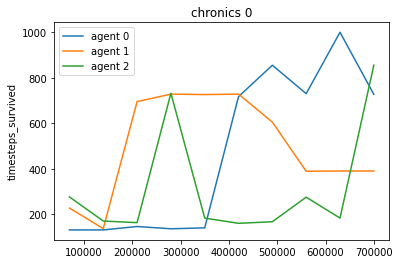

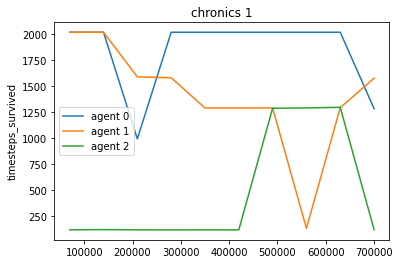

In [96]:
import matplotlib.pyplot as plt

for chronics_num in range(2):
    for k, y_name in enumerate(["timesteps_survived"]):
        plt.title("chronics " + str(chronics_num))
        plt.ylabel(y_name)
        for agent_num in range(len(agents_names_list)):
            plt.plot(nb_iterations_list, global_res[chronics_num, agent_num, 1], label="agent "+str(agent_num))
        plt.legend()
        plt.show()


## Learning rate function

In [121]:
def lr_fun(x_left):
    x = 1 - x_left
    lr = 0
    if x <= 0.25:
        lr = 1e-3 + (1e-5 - 1e-3) * x / 0.25
    else :
        lr = 1e-5
    return lr
    


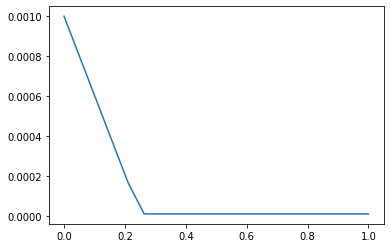

In [125]:
plt.plot(np.linspace(0,1,20), [lr_fun(1-el) for el in np.linspace(0,1,20)])


## Test CustomReward

In [9]:
env = grid2op.make(ENV_NAME, reward_class=CustomReward2)

In [57]:
def _sample_curtailment(env, rnd_update=None):
        unitary_actions = env.action_space.get_all_unitary_curtail(env.action_space)
        rnd_update = env.space_prng.choice(unitary_actions)
        return rnd_update

act = _sample_curtailment(env)
act.as_serializable_dict()

{'curtail': [(40, 0.6111111044883728)]}

In [86]:
act = _sample_curtailment(env)
print(act.as_serializable_dict())
obs, reward, done, info = env.step(act)
reward, done

{'curtail': [(16, 0.7777777910232544)]}


(0.1, False)

In [87]:
obs.curtailment_mw, obs.curtailment_limit_effective, obs.curtailment_limit

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.1325    , 1.        , 1.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.32933334, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 0.27066666, 1.        , 1.        , 1.        ,
        1.        , 1. 